In [2]:
#Import Libraries 
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd 
from PIL import Image
import glob
import numpy as np

In [3]:
#Load Data
import shutil
data_dir_train = '../input/plant-seedling-sharpened-saturated/train_sharpened_saturated/train_sharpened_saturated'
data_dir_test = '../input/plant-seedling-sharpened-saturated/test_sharpened_saturated'

In [4]:
#define parameters 
batch_size = 32
img_width = 224
img_height = 224 
epochs = 20

seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
#Split data
train_image_data = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1.0/255.0,
    rotation_range = 30,
    horizontal_flip = True, 
    vertical_flip = True,
    zoom_range=0.4, 
    shear_range = 0.3
)

train_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="training")

val_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [6]:
#Initialise test generator [794 images belonging to 1 class]
test_image_data = ImageDataGenerator(rescale=1./255)
test_ds = test_image_data.flow_from_directory(data_dir_test,
                                              classes=['test_sharpened_saturated'],
                                              target_size=(img_height,img_width),
                                              batch_size = 1,
                                              class_mode ='categorical',
                                              shuffle = False)

Found 794 images belonging to 1 classes.


In [7]:
train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size
test_steps = test_ds.samples

In [8]:
#Create Model
model = tf.keras.Sequential([
            tf.keras.applications.resnet_v2.ResNet152V2(input_shape=[224,224, 3], include_top=False, weights='imagenet'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(12, activation='softmax')
])

model.summary()

2021-11-27 04:23:56.936216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 04:23:57.042029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 04:23:57.042698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 04:23:57.044172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

234561536/234545216 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_______________________________________________________

In [9]:
#SGD
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#ADAM 
#from tensorflow.keras.optimizers import Adam
#opt = Adam(learning_rate=0.0005, epsilon=0.1)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#Save model checkpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
#Train Model
history =model.fit(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs,
                callbacks=[model_checkpoint_callback])

2021-11-27 04:24:06.475624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-27 04:24:20.215652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 119s 842ms/step - loss: 2.4371 - accuracy: 0.1809 - val_loss: 1.8543 - val_accuracy: 0.3836


2021-11-27 04:26:35.152703: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
118/118 [==============================] - 74s 629ms/step - loss: 1.7951 - accuracy: 0.4206 - val_loss: 1.2208 - val_accuracy: 0.6282


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/20
118/118 [==============================] - 74s 628ms/step - loss: 1.2939 - accuracy: 0.5797 - val_loss: 0.7910 - val_accuracy: 0.7619


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/20
118/118 [==============================] - 75s 636ms/step - loss: 0.9932 - accuracy: 0.6836 - val_loss: 0.6303 - val_accuracy: 0.8082


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20
118/118 [==============================] - 74s 630ms/step - loss: 0.8314 - accuracy: 0.7324 - val_loss: 0.5498 - val_accuracy: 0.8211


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/20
118/118 [==============================] - 74s 627ms/step - loss: 0.7032 - accuracy: 0.7767 - val_loss: 0.4788 - val_accuracy: 0.8416


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/20
118/118 [==============================] - 75s 636ms/step - loss: 0.6191 - accuracy: 0.8014 - val_loss: 0.4193 - val_accuracy: 0.8610


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/20
118/118 [==============================] - 75s 633ms/step - loss: 0.5509 - accuracy: 0.8268 - val_loss: 0.4432 - val_accuracy: 0.8513
Epoch 9/20
118/118 [==============================] - 74s 624ms/step - loss: 0.5082 - accuracy: 0.8327 - val_loss: 0.3726 - val_accuracy: 0.8847


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/20
118/118 [==============================] - 74s 630ms/step - loss: 0.4474 - accuracy: 0.8481 - val_loss: 0.3457 - val_accuracy: 0.8836
Epoch 11/20
118/118 [==============================] - 75s 633ms/step - loss: 0.4323 - accuracy: 0.8573 - val_loss: 0.3277 - val_accuracy: 0.9030


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/20
118/118 [==============================] - 74s 630ms/step - loss: 0.3889 - accuracy: 0.8693 - val_loss: 0.3466 - val_accuracy: 0.8922
Epoch 13/20
118/118 [==============================] - 75s 632ms/step - loss: 0.3689 - accuracy: 0.8727 - val_loss: 0.3152 - val_accuracy: 0.9073


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/20
118/118 [==============================] - 78s 660ms/step - loss: 0.3582 - accuracy: 0.8823 - val_loss: 0.3286 - val_accuracy: 0.8987
Epoch 15/20
118/118 [==============================] - 76s 642ms/step - loss: 0.3309 - accuracy: 0.8862 - val_loss: 0.3022 - val_accuracy: 0.9116


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/20
118/118 [==============================] - 76s 639ms/step - loss: 0.3003 - accuracy: 0.9011 - val_loss: 0.3322 - val_accuracy: 0.8987
Epoch 17/20
118/118 [==============================] - 74s 624ms/step - loss: 0.3058 - accuracy: 0.8947 - val_loss: 0.2974 - val_accuracy: 0.9095
Epoch 18/20
118/118 [==============================] - 74s 627ms/step - loss: 0.2847 - accuracy: 0.8982 - val_loss: 0.2810 - val_accuracy: 0.9224


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/20
118/118 [==============================] - 74s 627ms/step - loss: 0.2869 - accuracy: 0.9014 - val_loss: 0.2996 - val_accuracy: 0.9127
Epoch 20/20
118/118 [==============================] - 74s 629ms/step - loss: 0.2744 - accuracy: 0.9059 - val_loss: 0.3148 - val_accuracy: 0.9149


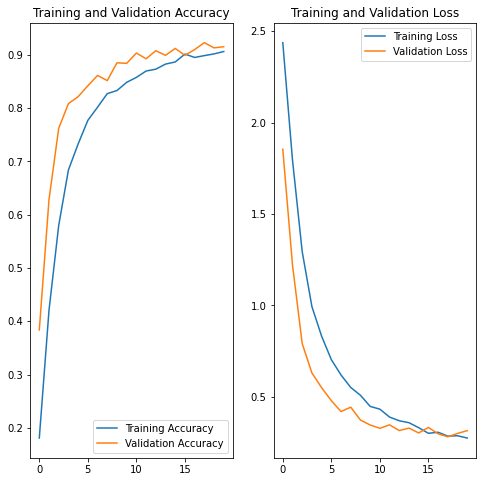

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.evaluate_generator(generator=val_ds, steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2949557900428772, 0.9148706793785095]

In [14]:
test_ds.reset() #maintain test order
test_predictions = model.predict(test_ds, test_ds.samples, verbose=1 )

794/794 [==============================] - 26s 29ms/step


In [15]:
predicted_plant_type = np.argmax(test_predictions, axis=1)

labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_plant_type]

test_pred = []
filenames=test_ds.filenames
for name in range(len(filenames)):
   test_pred.append(filenames[name].split('/')[1])

results=pd.DataFrame({"file":test_pred,
                      "species":predictions})
results.to_csv("submission.csv",index=False)